
# Demonstration of the Hybrid Kernelised Expaction Maximisation (HKEM) reconstruction with SIRF
This demonstration shows how to use HKEM and investigate the role of each kernel parameter in edge preservation and noise suppression.


Authors: Daniel Deidda, Kris Thielemans and Evgueni Ovtchinnikov, Richard Brown
First version: 30th of September 2019  
Second Version: 6th of November 2019

CCP PETMR Synergistic Image Reconstruction Framework (SIRF)  
Copyright 2019  National Physical Laboratory
Copyright 2019  Rutherford Appleton Laboratory STFC  
Copyright 2019  University College London.

This is software developed for the Collaborative Computational
Project in Positron Emission Tomography and Magnetic Resonance imaging
(http://www.ccppetmr.ac.uk/).

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

N.B.: You need to have run the [brainweb](./BrainWeb.ipynb) notebook first.

## Further reading!

Lastly, if you wish to see the mathematically formulations in this notebook, check out the original article by D. Deidda et al. (2019), available here: https://iopscience.iop.org/article/10.1088/1361-6420/ab013f.

In [1]:
#%% make sure figures appears inline and animations works
%matplotlib notebook

In [2]:
#%% Initial imports etc
import numpy
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import sys
import shutil
import string
#import scipy
#from scipy import optimize
import sirf.STIR as pet
from sirf.Utilities import examples_data_path
#os.getcwd()

# Get to correct directory
os.chdir(examples_data_path('Synergistic'))

#%% copy files to working folder and change directory to where the output files are
shutil.rmtree('working_folder/HKEM',True)
shutil.copytree('brainweb','working_folder/HKEM')
os.chdir('working_folder/HKEM')

In [3]:
#%% some handy function definitions
def imshow(image, limits, title=''):
    """Usage: imshow(image, [min,max], title)"""
    plt.title(title)
    bitmap = plt.imshow(image)
    if len(limits)==0:
        limits = [image.min(), image.max()]

    plt.clim(limits[0], limits[1])
    plt.colorbar(shrink=.6)
    plt.axis('off')
    return bitmap

def make_positive(image_array):
    """truncate any negatives to zero"""
    image_array[image_array<0] = 0
    return image_array

def make_cylindrical_FOV(image):
    """truncate to cylindrical FOV"""
    filter = pet.TruncateToCylinderProcessor()
    filter.apply(image)

### Load some data and set some values

In [4]:
full_sino = pet.AcquisitionData('FDG_sino_noisy.hs')

# if you want to make things faster you can rebin your data by compressing axial and view bins
# this will affect the quality of the reconstructed images
sino = full_sino.rebin(1,1)

#%% the following multiplication is just in case the noise sinogram has a different scale from the noiseless
# you can remove it in a real data situation
sino = sino*1000

atten = pet.ImageData('uMap_small.hv')

# Anatomical image
anatomical = pet.ImageData('T1_small.hv')
anatomical.fill(make_positive(anatomical.as_array()))

#%%  create initial image
init_image=atten.get_uniform_copy(atten.as_array().max()*.1)
make_cylindrical_FOV(init_image)

In [5]:
image = pet.ImageData('FDG_small.hv')
image_array = image.as_array()
#%% save max for future displays
cmax = image_array.max()*.6

<IPython.core.display.Javascript object>


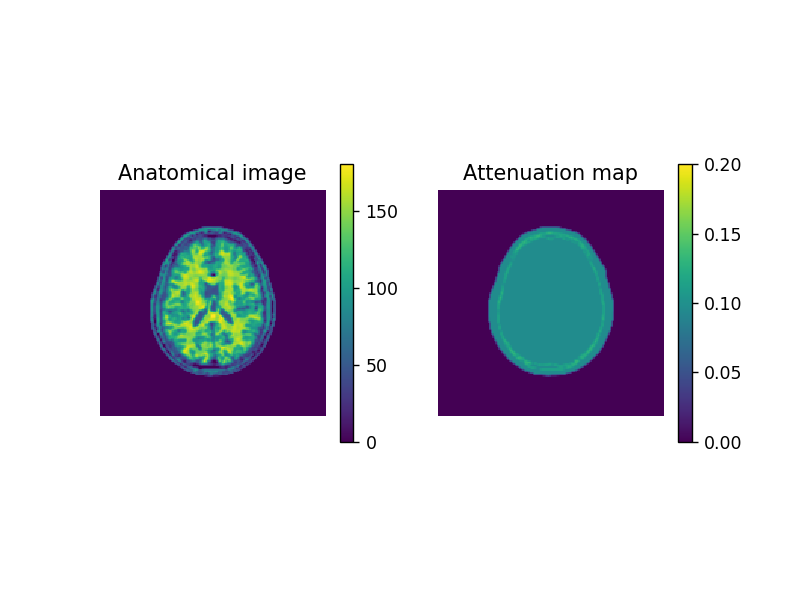

In [6]:
## Show anatomical image and attenuation map
anatomical_array=anatomical.as_array()
atten_array=atten.as_array()
im_slice = atten_array.shape[0]//2

plt.figure()
plt.subplot(1,2,1)
imshow(anatomical_array[im_slice,:,:,], [0,180],'Anatomical image')
plt.subplot(1,2,2)
imshow(atten_array[im_slice,:,:,], [0,0.2], 'Attenuation map')

## Set up the acquisition model and objective function

In [7]:
#%% create acquisition model
am = pet.AcquisitionModelUsingRayTracingMatrix()
am.set_num_tangential_LORs(5)

# Set up sensitivity due to attenuation
asm_attn = pet.AcquisitionSensitivityModel(atten, am)
asm_attn.set_up(sino)
bin_eff = pet.AcquisitionData(sino)
bin_eff.fill(1.0)
asm_attn.unnormalise(bin_eff)
asm_attn = pet.AcquisitionSensitivityModel(bin_eff)

# Set sensitivity of the model and set up
am.set_acquisition_sensitivity(asm_attn)
am.set_up(sino,atten);

#%% create objective function
obj_fun = pet.make_Poisson_loglikelihood(sino)
obj_fun.set_acquisition_model(am)

##  create KOSMAPOSL reconstructor
This implements the Ordered Subsets HKEM
In this section we define all parameter

In [8]:
recon = pet.KOSMAPOSLReconstructor()
recon.set_objective_function(obj_fun)

recon.set_input(sino)

recon.set_anatomical_prior(anatomical)
recon.set_only_2D(True)
recon.set_num_non_zero_features(1)

In [9]:
#Reconstruct an example with 4 iterations before the parameter selection (around 9 min)
recon.set_num_subsets(7)
recon.set_num_subiterations(28)

#fix  parameters
recon.set_num_neighbours(5)
recon.set_sigma_m(0.2)
recon.set_sigma_p(0.2)
recon.set_sigma_dm(3.0)
recon.set_sigma_dp(3.0)

H1ex_reconstructed_image=(init_image.clone())
H0ex_reconstructed_image=(init_image.clone())

#   reconstruct using side information from MR and PET (H0 is KEM H1 is HKEM)
output_prefix = "Example_HKEM"
#   set up the reconstructor
recon.set_output_filename_prefix(output_prefix)
recon.set_hybrid(True)
recon.set_up(H1ex_reconstructed_image)
recon.reconstruct(H1ex_reconstructed_image)

#   reconstruct using only side information from MR (H0 is KEM H1 is HKEM)
output_prefix = "Example_KEM"
#   set up the reconstructor
recon.set_output_filename_prefix(output_prefix)
recon.set_hybrid(False)
recon.set_up(H0ex_reconstructed_image)
recon.reconstruct(H0ex_reconstructed_image)
    

##  Plot Reconstructed images

<IPython.core.display.Javascript object>


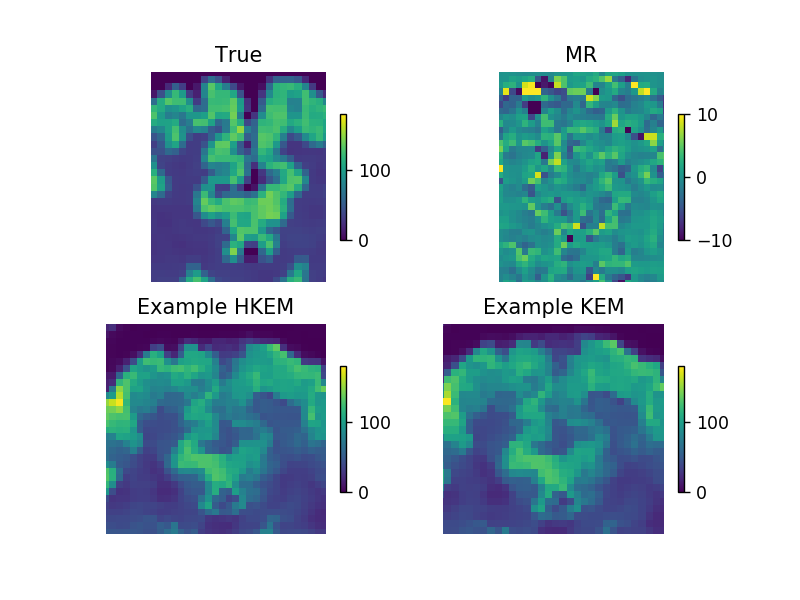

In [15]:
H1ex_reconstructed_array=H1ex_reconstructed_image.as_array()
H0ex_reconstructed_array=H0ex_reconstructed_image.as_array()

plt.figure()
plt.subplot(2,2,1)
imshow(image_array[im_slice,:,:,], [0,180],'True')
plt.subplot(2,2,2)
imshow(anatomical_array[im_slice,:,:,], [0,180],'MR')
plt.subplot(2,2,3)
imshow(H0ex_reconstructed_array[im_slice,:,:,], [0,180],'Example HKEM')
plt.subplot(2,2,4)
imshow(H1ex_reconstructed_array[im_slice,:,:,], [0,180], 'Example KEM')

##  exercise: calculate the difference between HKEM and KEM and plot the image. Try to explain what are the reasons for these differences

In [ ]:
# exercise:



## Study parameter "neighbourhood size", n
try to rebin the data if it is too slow (sino.rebin(segments, views) )

In [16]:
#%% reconstruct the image 
H1n_reconstructed_image = [] 
H0n_reconstructed_image = []

num_subsets = 7
num_subiters = 21
recon.set_num_subsets(num_subsets)
recon.set_num_subiterations(num_subiters)

#fix other parameters
recon.set_sigma_m(0.2)
recon.set_sigma_p(0.2)
recon.set_sigma_dm(3.0)
recon.set_sigma_dp(3.0)

n={3, 5, 7}
ii=0
for i in n:

    H1n_reconstructed_image.append(init_image.clone())
    H0n_reconstructed_image.append(init_image.clone())

    recon.set_num_neighbours(i)
    j="{}".format(i)
    jj=j.replace(".", "_")

#   reconstruct using side information from MR and PET (H0 is KEM H1 is HKEM)
    output_prefix = "H1_N{}".format(jj)
#   set up the reconstructor
    recon.set_output_filename_prefix(output_prefix)
    recon.set_hybrid(True)
    recon.set_up(H1n_reconstructed_image[ii])
    recon.reconstruct(H1n_reconstructed_image[ii])

#   reconstruct using only side information from MR (H0 is KEM H1 is HKEM)
    output_prefix = "H0_N{}".format(jj)
#   set up the reconstructor
    recon.set_output_filename_prefix(output_prefix)
    recon.set_hybrid(False)
    recon.set_up(H0n_reconstructed_image[ii])
    recon.reconstruct(H0n_reconstructed_image[ii])
    ii=ii+1;

<IPython.core.display.Javascript object>


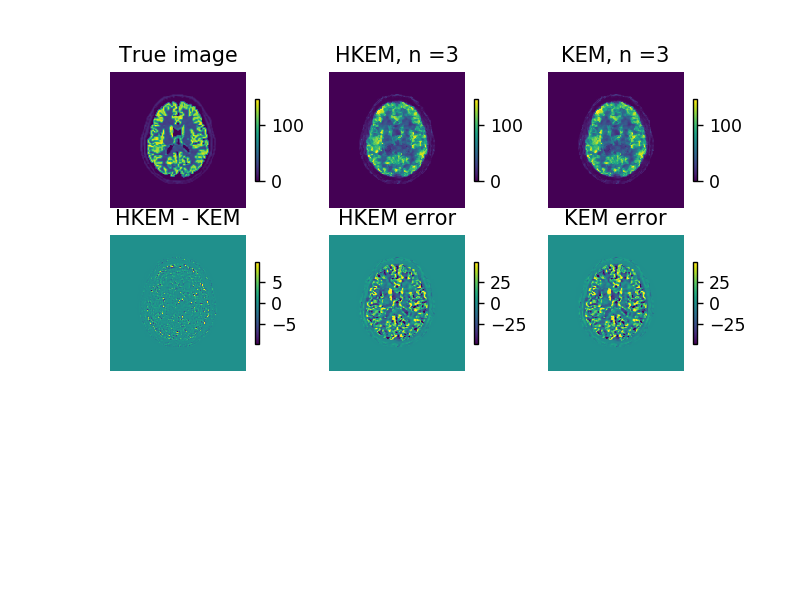

<IPython.core.display.Javascript object>


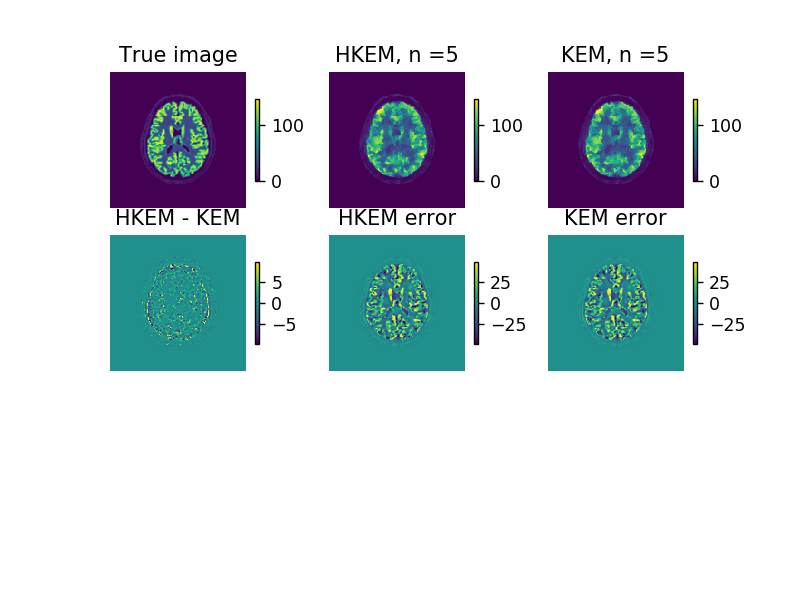

<IPython.core.display.Javascript object>


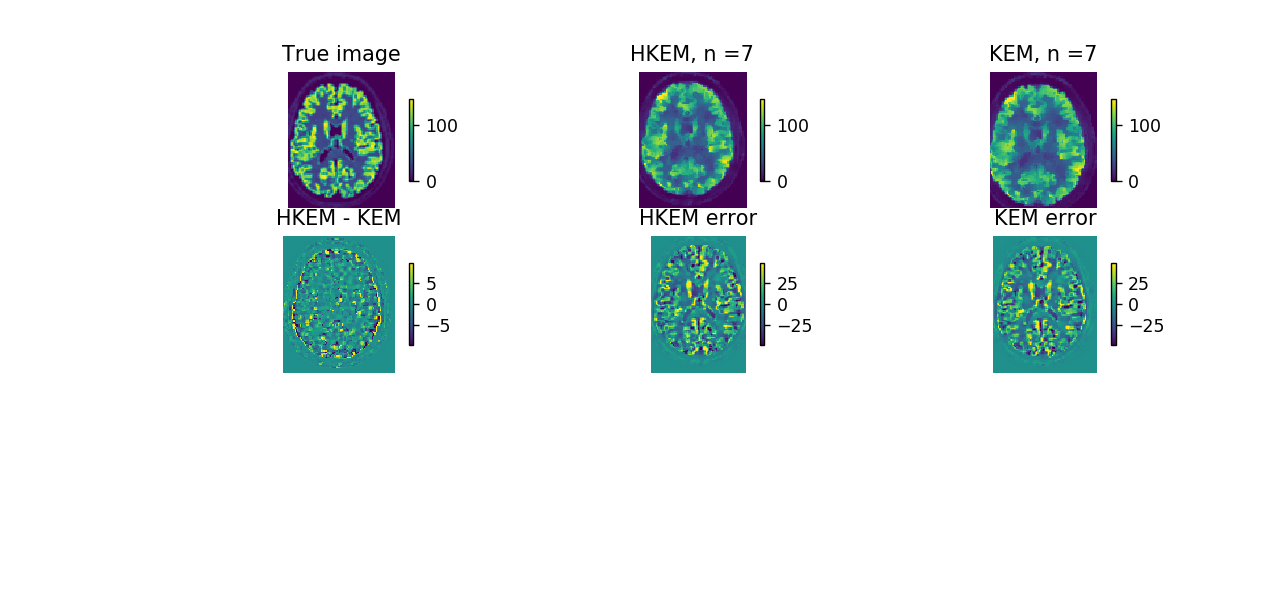

In [17]:
#%% bitmap display of images
# define lists

H1n_reconstructed_array = []
H0n_reconstructed_array = []
diffn_image_array = []
H1n_error_array = []
H0n_error_array = []
ii=0

for i in n:

    j="{}".format(i)
    jj=j.replace(".", "_")
    #H0n_reconstructed_image[ii]=pet.ImageData('H0_N'+jj+'_12.hv')
    H1n_reconstructed_array.append(H1n_reconstructed_image[ii].as_array())
    H0n_reconstructed_array.append(H0n_reconstructed_image[ii].as_array())

#   anatomical_image_array = anatomical_image.as_array()
    diffn_image_array.append(H1n_reconstructed_array[ii] - H0n_reconstructed_array[ii])
    H1n_error_array.append(image_array - H1n_reconstructed_array[ii])
    H0n_error_array.append(image_array - H0n_reconstructed_array[ii])

    plt.figure()
    plt.subplot(3,3,1)
    imshow(image_array[im_slice,:,:,], [0,cmax*1.5],'True image')
    plt.subplot(3,3,2)
    imshow(H1n_reconstructed_array[ii][im_slice,:,:,], [0,cmax*1.5], 'HKEM, n ='+j)
    plt.subplot(3,3,3)
    imshow(H0n_reconstructed_array[ii][im_slice,:,:,], [0,cmax*1.5], 'KEM, n ='+j)
    plt.subplot(3,3,4)
    imshow(diffn_image_array[ii][im_slice,:,:,], [-cmax*0.1,cmax*0.1], 'HKEM - KEM');
    plt.subplot(3,3,5)
    imshow(H1n_error_array[ii][im_slice,:,:,], [-cmax*0.5,cmax*0.5], 'HKEM error')
    plt.subplot(3,3,6)
    imshow(H0n_error_array[ii][im_slice,:,:,], [-cmax*0.5,cmax*0.5], 'KEM error')

    ii=ii+1;

## Study parameter sigma_m (MR edge preservation) 
#this takes around 30 min


In [18]:
#%% reconstruct the image 
H1m_reconstructed_image = [] 
H0m_reconstructed_image = []

#fix other parameters
recon.set_num_neighbours(5)
recon.set_sigma_p(0.2)
recon.set_sigma_dm(3.0)
recon.set_sigma_dp(3.0)

sigma_m={0.05, 0.2, 1, 3, 5}
ii=0
for i in sigma_m:

    H1m_reconstructed_image.append(init_image.clone())
    H0m_reconstructed_image.append(init_image.clone())

    recon.set_sigma_m(i)
    j="{}".format(i)
    jj=j.replace(".", "_")

#   reconstruct using side information from MR and PET (H0 is KEM H1 is HKEM)
    output_prefix = "H1_N5_M{}".format(jj)
#   set up the reconstructor
    recon.set_output_filename_prefix(output_prefix)
    recon.set_hybrid(True)
    recon.set_up(H1m_reconstructed_image[ii])
    recon.reconstruct(H1m_reconstructed_image[ii])

#   reconstruct using only side information from MR (H0 is KEM H1 is HKEM)
    output_prefix = "H0_N5_M{}".format(jj)
#   set up the reconstructor
    recon.set_output_filename_prefix(output_prefix)
    recon.set_hybrid(False)
    recon.set_up(H0m_reconstructed_image[ii])
    recon.reconstruct(H0m_reconstructed_image[ii])
    ii=ii+1;

<IPython.core.display.Javascript object>


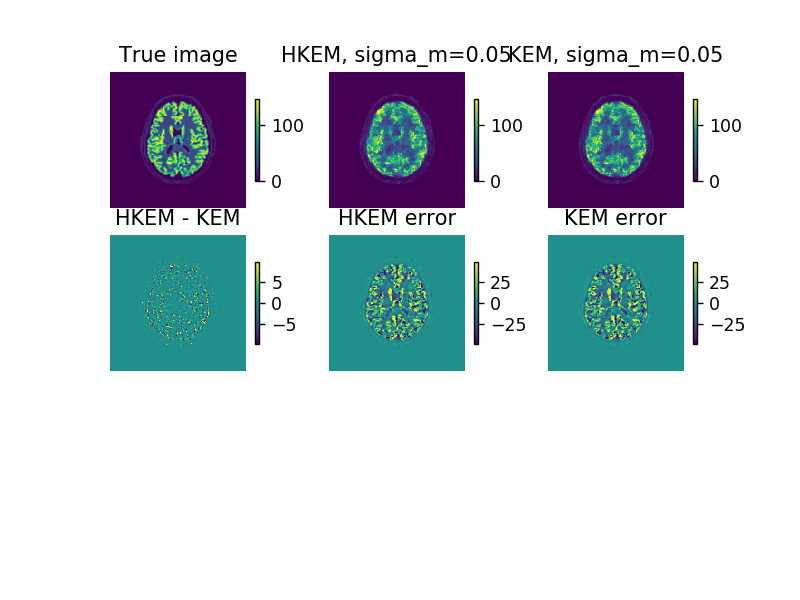

<IPython.core.display.Javascript object>


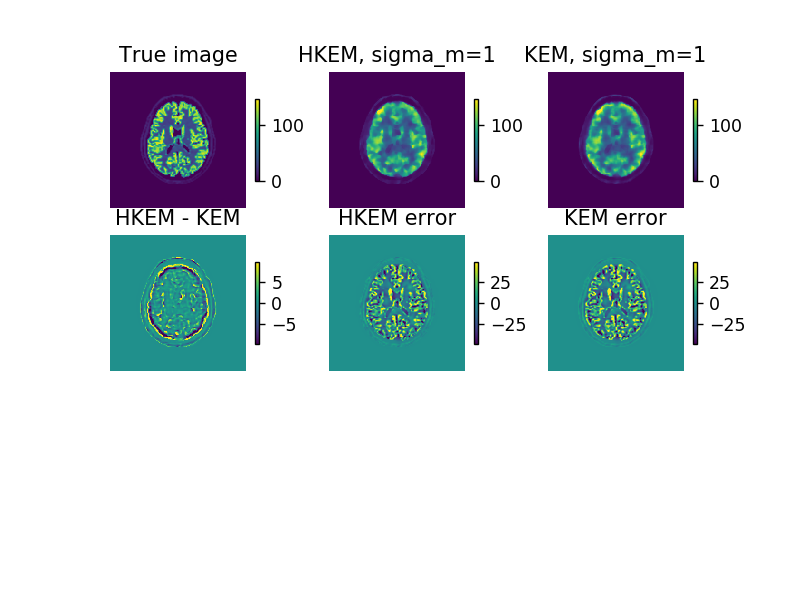

<IPython.core.display.Javascript object>


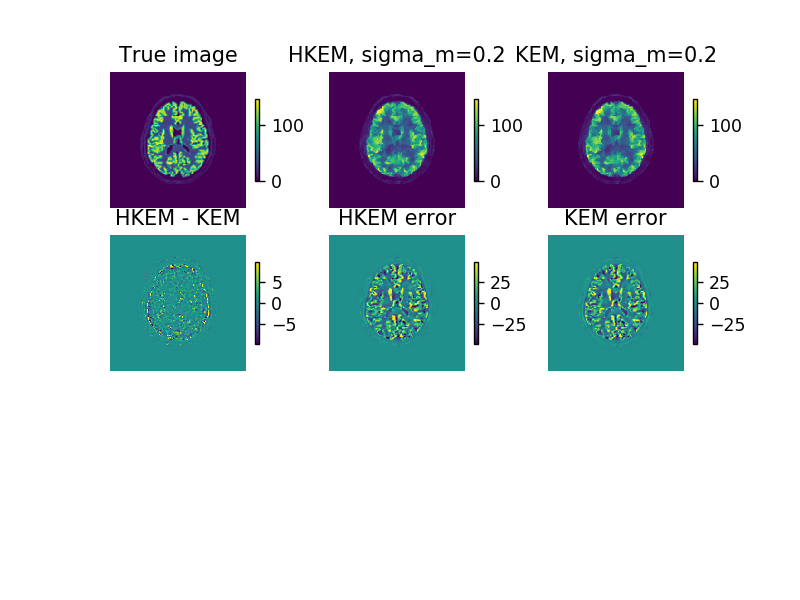

<IPython.core.display.Javascript object>


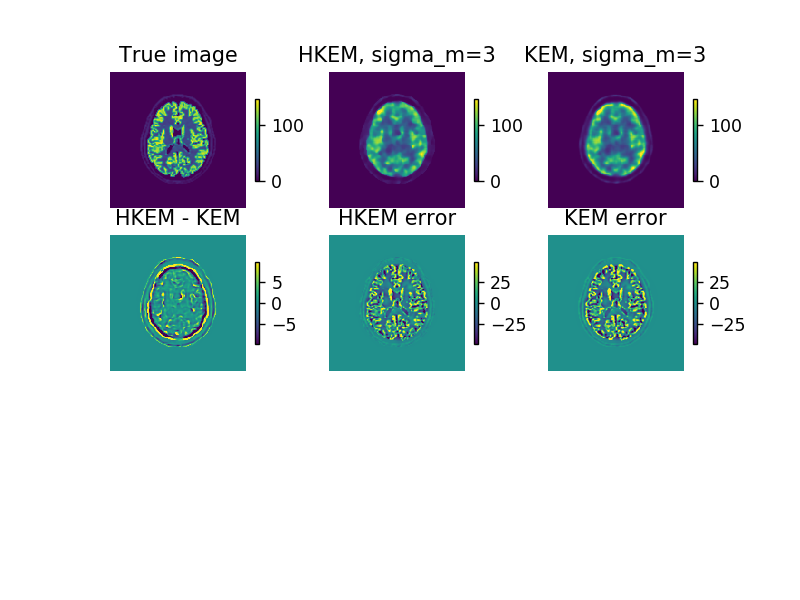

<IPython.core.display.Javascript object>


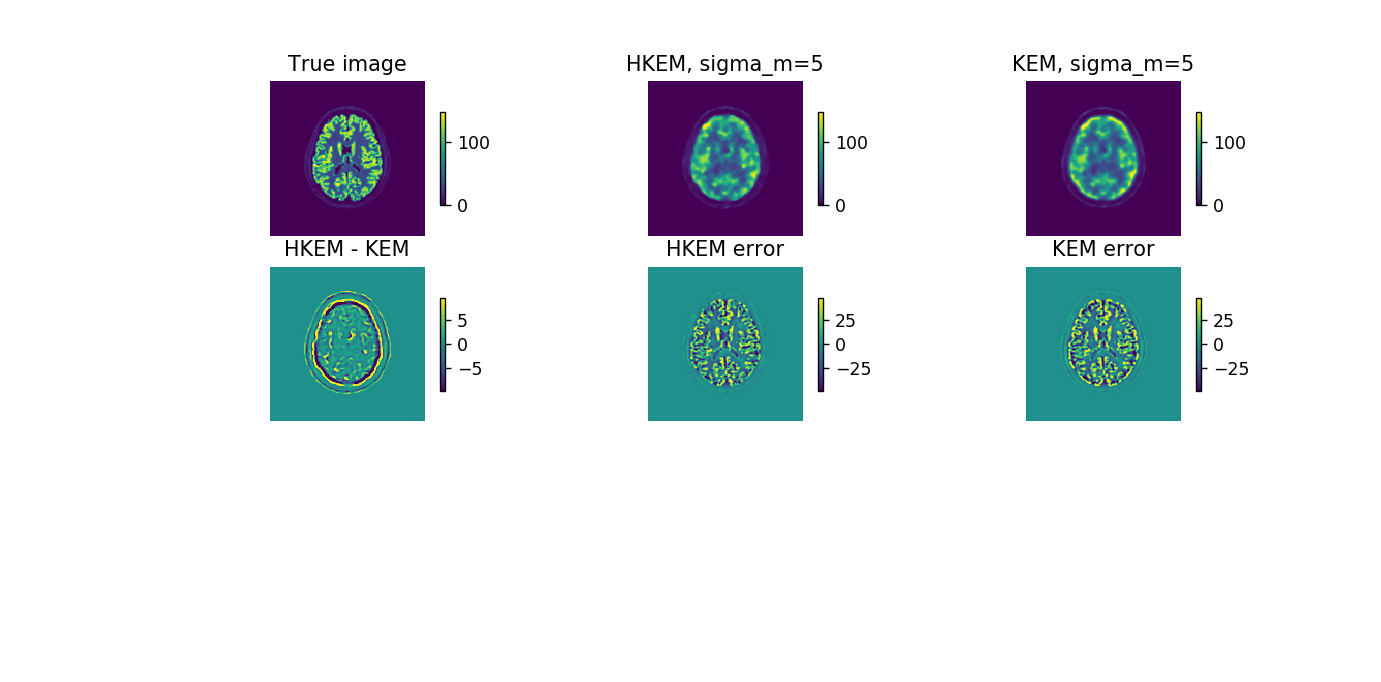

In [19]:
#%% bitmap display of images
# define lists
H1m_reconstructed_array = []
H0m_reconstructed_array = []
diffm_image_array = []
H1m_error_array = []
H0m_error_array = []
ii=0
#sigma_m={0.1, 0.5, 1, 3, 5}
for i in sigma_m:

    j="{}".format(i)
    jj=j.replace(".", "_")

    H1m_reconstructed_array.append(H1m_reconstructed_image[ii].as_array())
    H0m_reconstructed_array.append(H0m_reconstructed_image[ii].as_array())

#   anatomical_image_array = anatomical_image.as_array()
    diffm_image_array.append(H1m_reconstructed_array[ii] - H0m_reconstructed_array[ii])
    H1m_error_array.append(image_array - H1m_reconstructed_array[ii])
    H0m_error_array.append(image_array - H0m_reconstructed_array[ii])

    plt.figure()
    plt.subplot(3,3,1)
    imshow(image_array[im_slice,:,:,], [0,cmax*1.5],'True image')
    plt.subplot(3,3,2)
    imshow(H1m_reconstructed_array[ii][im_slice,:,:,], [0,cmax*1.5], 'HKEM, sigma_m='+j)
    plt.subplot(3,3,3)
    imshow(H0m_reconstructed_array[ii][im_slice,:,:,], [0,cmax*1.5], 'KEM, sigma_m='+j)
    plt.subplot(3,3,4)
    imshow(diffm_image_array[ii][im_slice,:,:,], [-cmax*0.1,cmax*0.1], 'HKEM - KEM');
    plt.subplot(3,3,5)
    imshow(H1m_error_array[ii][im_slice,:,:,], [-cmax*0.5,cmax*0.5], 'HKEM error')
    plt.subplot(3,3,6)
    imshow(H0m_error_array[ii][im_slice,:,:,], [-cmax*0.5,cmax*0.5], 'KEM error')

    ii=ii+1;

## Study parameter sigma_p (PET edge preservation)


In [20]:
#%% reconstruct the image 
H1p_reconstructed_image = [] 
H0p_reconstructed_image = []

#fix other parameters
recon.set_num_neighbours(5)
recon.set_sigma_m(0.5)
recon.set_sigma_dm(3.0)
recon.set_sigma_dp(3.0)

sigma_p={0.05, 0.2, 1, 3, 5}
ii=0
for i in sigma_p:

    H1p_reconstructed_image.append(init_image.clone())
    H0p_reconstructed_image.append(init_image.clone())

    recon.set_sigma_p(i)
    j="{}".format(i)
    jj=j.replace(".", "_")

#   reconstruct using side information from MR and PET (H0 is KEM H1 is HKEM)
    output_prefix = "H1_N5_P{}".format(jj)
#   set up the reconstructor
    recon.set_output_filename_prefix(output_prefix)
    recon.set_hybrid(True)
    recon.set_up(H1p_reconstructed_image[ii])
    recon.reconstruct(H1p_reconstructed_image[ii])

#   reconstruct using only side information from MR (H0 is KEM H1 is HKEM)
    output_prefix = "H0_N5_P{}".format(jj)
#   set up the reconstructor
    recon.set_output_filename_prefix(output_prefix)
    recon.set_hybrid(False)
    recon.set_up(H0p_reconstructed_image[ii])
    recon.reconstruct(H0p_reconstructed_image[ii])
    ii=ii+1;

In [ ]:
#%% bitmap display of images
# define lists
H1p_reconstructed_array = []
H0p_reconstructed_array = []
diffp_image_array = []
H1p_error_array = []
H0p_error_array = []
ii=0

for i in sigma_p:

    j="{}".format(i)
    jj=j.replace(".", "_")

    H1p_reconstructed_array.append(H1p_reconstructed_image[ii].as_array())
    H0p_reconstructed_array.append(H0p_reconstructed_image[ii].as_array())

#   anatomical_image_array = anatomical_image.as_array()
    diffp_image_array.append(H1p_reconstructed_array[ii] - H0p_reconstructed_array[ii])
    H1p_error_array.append(image_array - H1p_reconstructed_array[ii])
    H0p_error_array.append(image_array - H0p_reconstructed_array[ii])

    plt.figure()
    plt.subplot(3,3,1)
    imshow(image_array[im_slice,:,:,], [0,cmax*1.5],'True image')
    plt.subplot(3,3,2)
    imshow(H1p_reconstructed_array[ii][im_slice,:,:,], [0,cmax*1.5], 'HKEM, sigma_p='+j)
    plt.subplot(3,3,3)
    imshow(H0p_reconstructed_array[ii][im_slice,:,:,], [0,cmax*1.5], 'KEM, sigma_p='+j)
    plt.subplot(3,3,4)
    imshow(diffp_image_array[ii][im_slice,:,:,], [-cmax*0.1,cmax*0.1], 'HKEM - KEM');
    plt.subplot(3,3,5)
    imshow(H1p_error_array[ii][im_slice,:,:,], [-cmax*0.5,cmax*0.5], 'HKEM error')
    plt.subplot(3,3,6)
    imshow(H0p_error_array[ii][im_slice,:,:,], [-cmax*0.5,cmax*0.5], 'KEM error')

    ii=ii+1;

## Study parameter sigma_d (smoothing)


In [ ]:
#%% reconstruct the image 
H1d_reconstructed_image = [] 
H0d_reconstructed_image = []

#fix other parameters
recon.set_num_neighbours(5)
recon.set_sigma_m(0.1)
recon.set_sigma_p(0.1)

sigma_dm={0.1, 0.5, 1, 3, 5}
ii=0
for i in sigma_dm:

    H1d_reconstructed_image.append(init_image.clone())
    H0d_reconstructed_image.append(init_image.clone())

    recon.set_sigma_dp(i)
    recon.set_sigma_dm(i)

    j="{}".format(i)
    jj=j.replace(".", "_")

#   reconstruct using side information from MR and PET (H0 is KEM H1 is HKEM)
    output_prefix = "H1_N5_D{}".format(jj)
#   set up the reconstructor
    recon.set_output_filename_prefix(output_prefix)
    recon.set_hybrid(True)
    recon.set_up(H1d_reconstructed_image[ii])
    recon.reconstruct(H1d_reconstructed_image[ii])

#   reconstruct using only side information from MR (H0 is KEM H1 is HKEM)
    output_prefix = "H0_N5_D{}".format(jj)
#   set up the reconstructor
    recon.set_output_filename_prefix(output_prefix)
    recon.set_hybrid(False)
    recon.set_up(H0d_reconstructed_image[ii])
    recon.reconstruct(H0d_reconstructed_image[ii])
    ii=ii+1;

In [ ]:
#%% bitmap display of images
# define lists
H1d_reconstructed_array = []
H0d_reconstructed_array = []
diffd_image_array = []
H1d_error_array = []
H0d_error_array = []
ii=0

for i in sigma_dm:

    j="{}".format(i)
    jj=j.replace(".", "_")

    H1d_reconstructed_array.append(H1d_reconstructed_image[ii].as_array())
    H0d_reconstructed_array.append(H0d_reconstructed_image[ii].as_array())

#   anatomical_image_array = anatomical_image.as_array()
    diffd_image_array.append(H1d_reconstructed_array[ii] - H0d_reconstructed_array[ii])
    H1d_error_array.append(image_array - H1d_reconstructed_array[ii])
    H0d_error_array.append(image_array - H0d_reconstructed_array[ii])

    plt.figure()
    plt.subplot(3,3,1)
    imshow(image_array[im_slice,:,:,], [0,cmax*1.5],'True image')
    plt.subplot(3,3,2)
    imshow(H1d_reconstructed_array[ii][im_slice,:,:,], [0,cmax*1.5], 'HKEM, sigma_d='+j)
    plt.subplot(3,3,3)
    imshow(H0d_reconstructed_array[ii][im_slice,:,:,], [0,cmax*1.5], 'KEM, sigma_d='+j)
    plt.subplot(3,3,4)
    imshow(diffd_image_array[ii][im_slice,:,:,], [-cmax*0.1,cmax*0.1], 'HKEM - KEM');
    plt.subplot(3,3,5)
    imshow(H1d_error_array[ii][im_slice,:,:,], [-cmax*0.5.,cmax*0.5.], 'HKEM error')
    plt.subplot(3,3,6)
    imshow(H0d_error_array[ii][im_slice,:,:,], [-cmax*0.5.,cmax*0.5.], 'KEM error')

    ii=ii+1
    